In [101]:
library(tidyverse)
options(repr.plot.width=10, repr.plot.height=6)
theme_set(theme_classic())

# STATS 504
## Week 9: Effect size and power

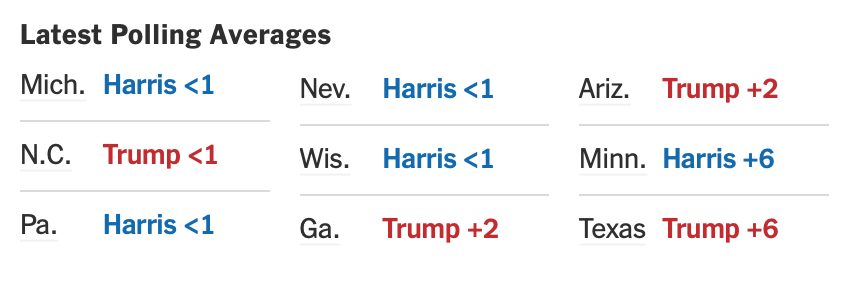

## What are we testing

$$H_0: p_\text{Trump} > 50\% \quad H_1: p_\text{Trump} \le 50 $$

## Types of statistical error

|                | $H_0$ true                    | $H_1$ true                   |
|----------------|----------------------------|---------------------------|
| Significant    | False Positive ($\alpha$)  | True Positive (1-$\beta$) |
| Nonsignificant | True Negative (1-$\alpha$) | False negative ($\beta$)  |

- Two mutually exclusive hypotheses: 
  - $H_0$: null hypothesis
  - $H_1$: alternative hypothesis
- Job: figure out which hypothesis is true
- Errors:
  - Type I ($\alpha$): incorrectly reject $H_0$ when $H_0$ is true
  - Type II ($\beta$): fail to reject $H_0$ when $H_1$ is true
- Power ($1-\beta$)
  - The probability of observing a significant result when $H_1$ is true.

## Power
Power is the probability of finding a significant result when there is an effect. Hence it depends on:
- Effect size (magnitude of the difference between $H_0$ and $H_1$)
- Sample size
- Error/noise
- The statistical procedure
- **How can I get $\alpha=0$ (no type-I error)?** What would my power be?
- **How can I get $\beta=0$ (power=1)?** What would my type-I error be?

In [157]:
# Parameters
population_size <- 8400000     # Registered voters in Michigan
true_percentage <- 0.48     # True percentage voting for the candidate
sample_sizes <- c(100, 500, 1000, 5000)  # Different sample sizes to test

set.seed(01/06/2021)

population <- data.frame(
    voter_id = 1:population_size,
    voting_for_candidate = rbinom(population_size, 1, true_percentage)
)

population %>% head

,voter_id,voting_for_candidate
,<int>,<int>
1,1,1
2,2,0
3,3,0
4,4,0
5,5,1
6,6,0


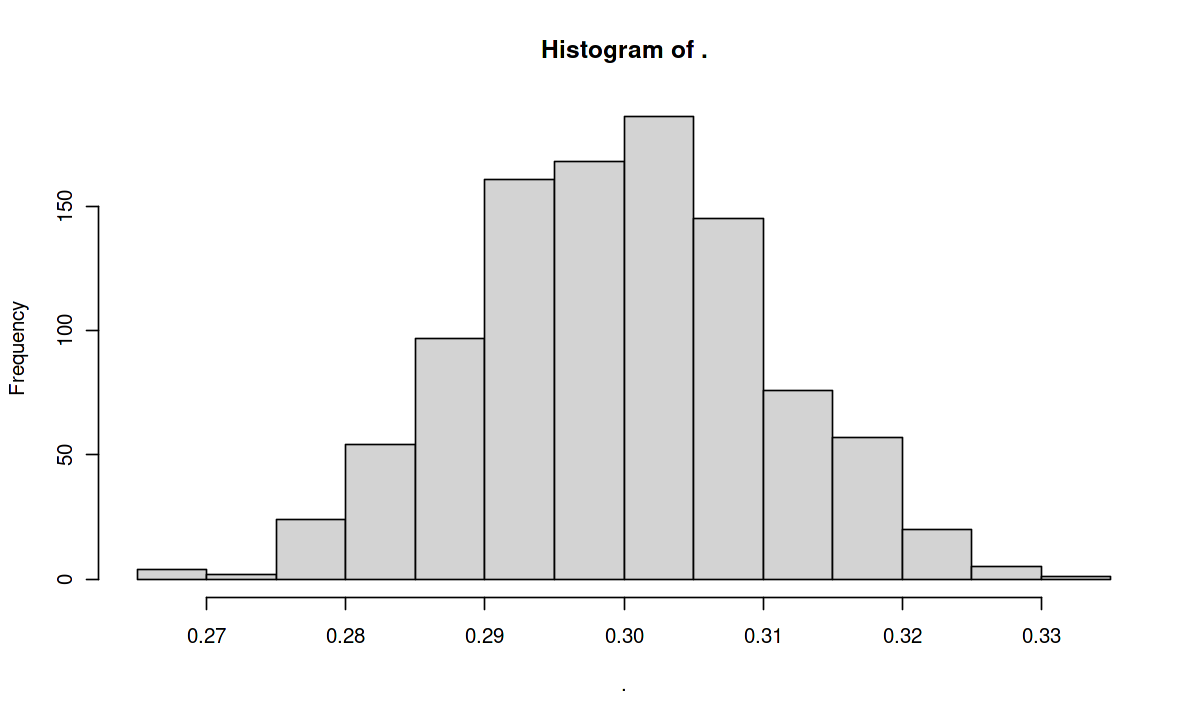

In [158]:
conduct_poll <- function (sample_size) {
    population %>% sample_n(size = sample_size) %>% pluck("voting_for_candidate") %>% mean
}

replicate(1000, conduct_poll(2000)) %>% hist

In [113]:
replicate(100, reject_null(1000)) %>% mean()

[1] 0

In [168]:
population$response_prob = ifelse(
    population$voting_for_candidate,
    0.7,
    0.3
)

population$lied <- rbinom(size = population_size, n = 1, prob = 0.01)

population$answer = ifelse(population$lied, 1 - population$voting_for_candidate, population$voting_for_candidate)

conduct_poll <- function (sample_size) {
    population %>% sample_n(size = sample_size, weight=response_prob) %>% 
        pluck("answer") %>% mean
}

In [169]:
replicate(100, conduct_poll(1000)) %>% hist

Having an underpowered study means:
- We might miss true effects.
- If we do find an effect, it will tend to be bigger than the true effect.
- There is a lower chance that a significant result is actually true.

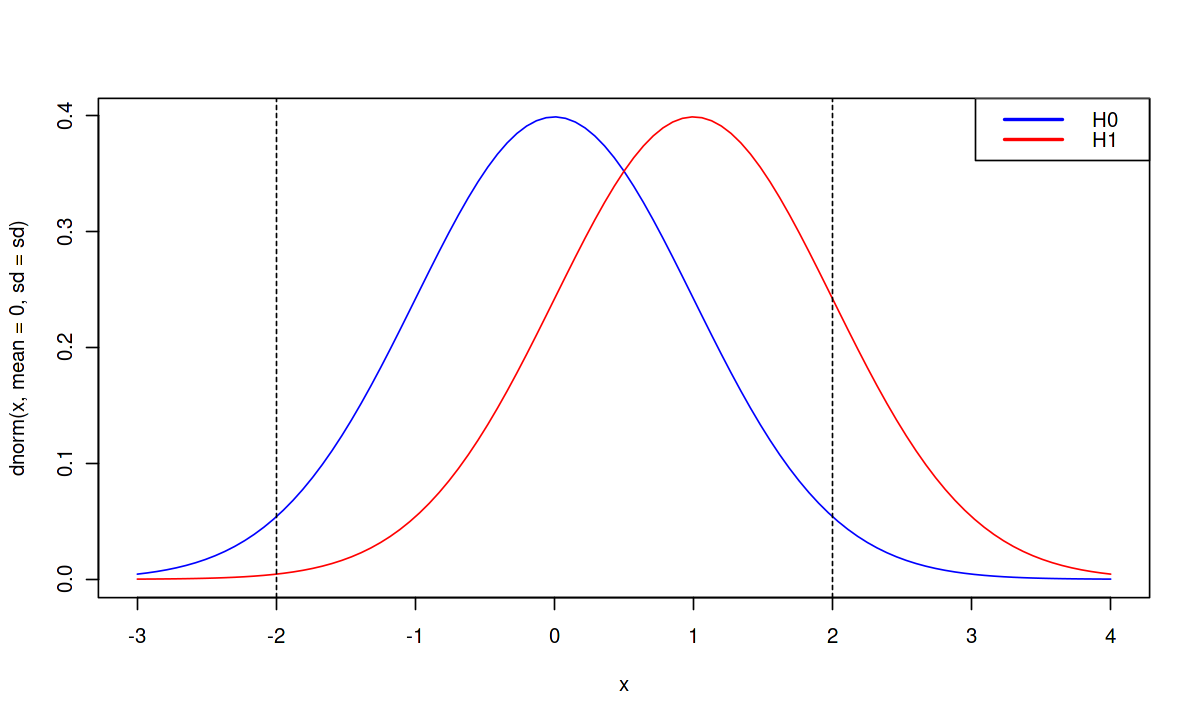

In [184]:
pwr_plot <- function(mu, n) {
    sd <- 1 / sqrt(n)
    curve(dnorm(x, mean=0, sd=sd), from=-3, to=3 + mu, col="blue")
    curve(dnorm(x, mean=mu, sd=sd), add=T, col="red")
    legend("topright", 
       legend = c("H0", "H1"),
       col = c("blue", "red"), 
       lwd = 2)
    abline(v=-2 * sd, lty=2)
    abline(v=2 * sd, lty=2)

}
pwr_plot(1, 1);

Suppose $\alpha=0.05$. What region(s) of this graph correspond to Type I and Type II error?

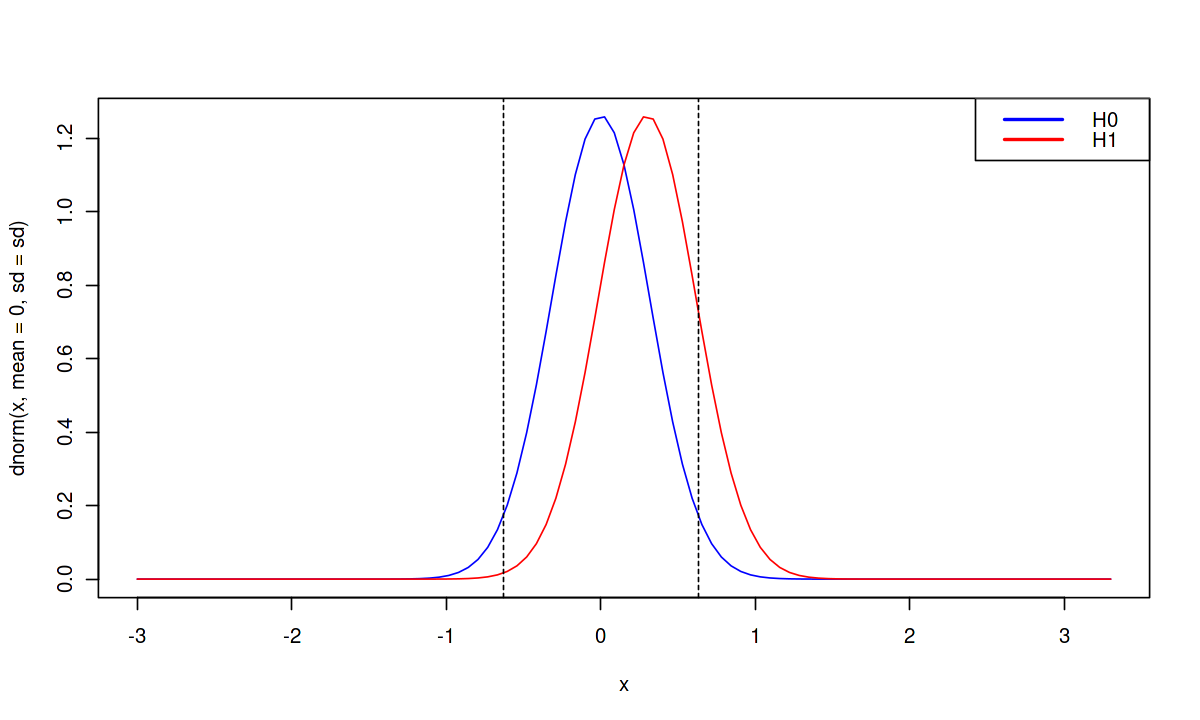

In [192]:
pwr_plot(.3, 10);

What's the effect size? What's the power?

In [2]:
# code

pnorm(2, mean = 1, lower.tail = F) +
pnorm(-2, mean = 1)

[1] 0.1600052

What if we increase the effect size?

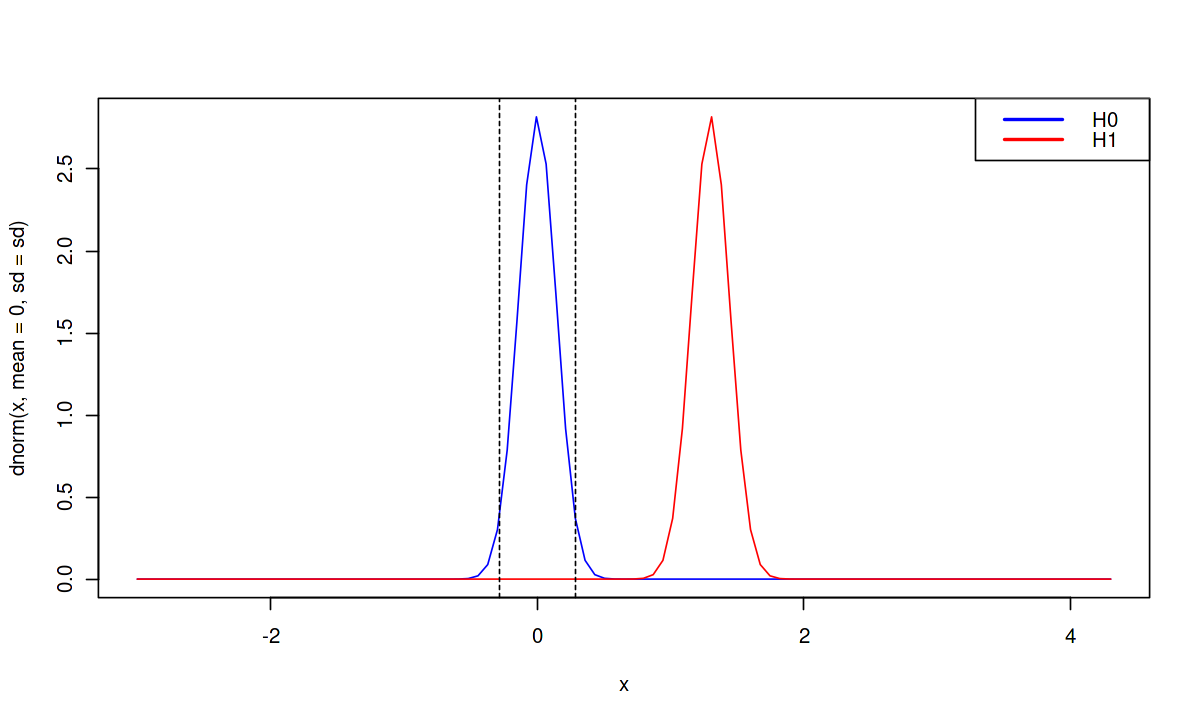

In [12]:
pwr_plot(1.3, 50)

Now what's the power?

What if we increase the sample size?

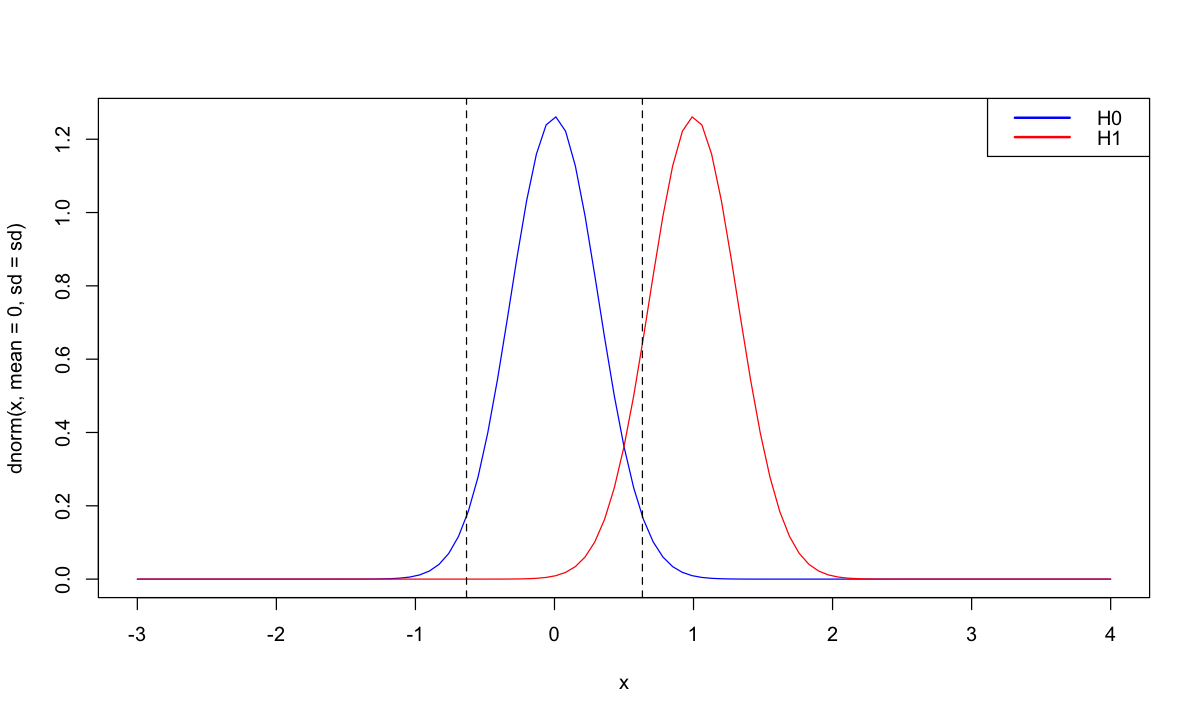

In [91]:
pwr_plot(1, 10)

Sample size and effect size work in similar ways. 

- If $\mu=1$ and $n=10$, the effect size is 1, and the power is:

In [114]:
x0 <- qnorm(.975, mean=0, sd=1 / sqrt(10))  # rejection region when n = 10
 # probability of observing a value larger than x0
1 - pnorm(x0, mean=1, sd=1 / sqrt(10))

[1] 0.885379

- If $\mu = \sqrt{10}$ and $n=1$, then the effect size is $\sqrt{10}$, and the power is:

In [147]:
1 - pnorm(2, mean=sqrt(10), sd=1)

[1] 0.8774387

## Inflating effects
- When power is low, a statistically significant finding is likely overstate the true effect size.
- Only an overestimate will pass the significance threshold.

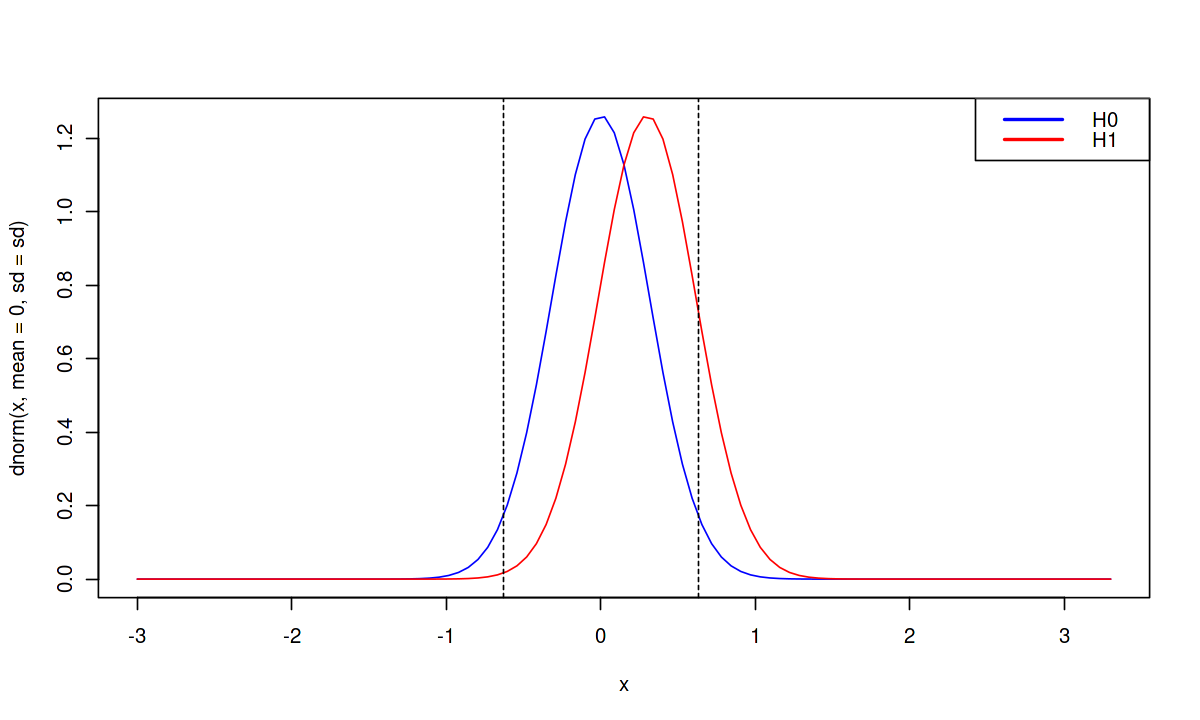

In [195]:
pwr_plot(.3, 10)
# abline(v=1, lty=2)

![ioniddas](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8e/Ioannidis_%282005%29_Why_Most_Published_Research_Findings_Are_False.pdf/page1-910px-Ioannidis_%282005%29_Why_Most_Published_Research_Findings_Are_False.pdf.jpg)

## How true is a study?

How many effects do we expect to find? 

- Let $R$ be the odds that there is an effect.
  - In other words, out of all the relationships we could test, $R$ is the number where there is an effect divided by the number where there is no effect.
  - The probability of a relationship being true is $R / (1 + R) =: p$.
- The **positive predictive value** is the probability that a claimed relationship is true:

$$
\text{PPV} = \mathbb{P}(\text{true} \mid \text{significant}) = \frac{p\times(1-\beta)}{p(1-\beta) + (1-p)\alpha}
$$

- $\implies \text{PPV} > 1/2 \iff R(1-\beta) > \alpha$

## Example
- Assume our hypothesis has a 25% chance of being true, and as usual we set $\alpha=0.05$.
- $\text{PPV} = \frac{(1-\beta)}{(1-\beta)+0.15}$


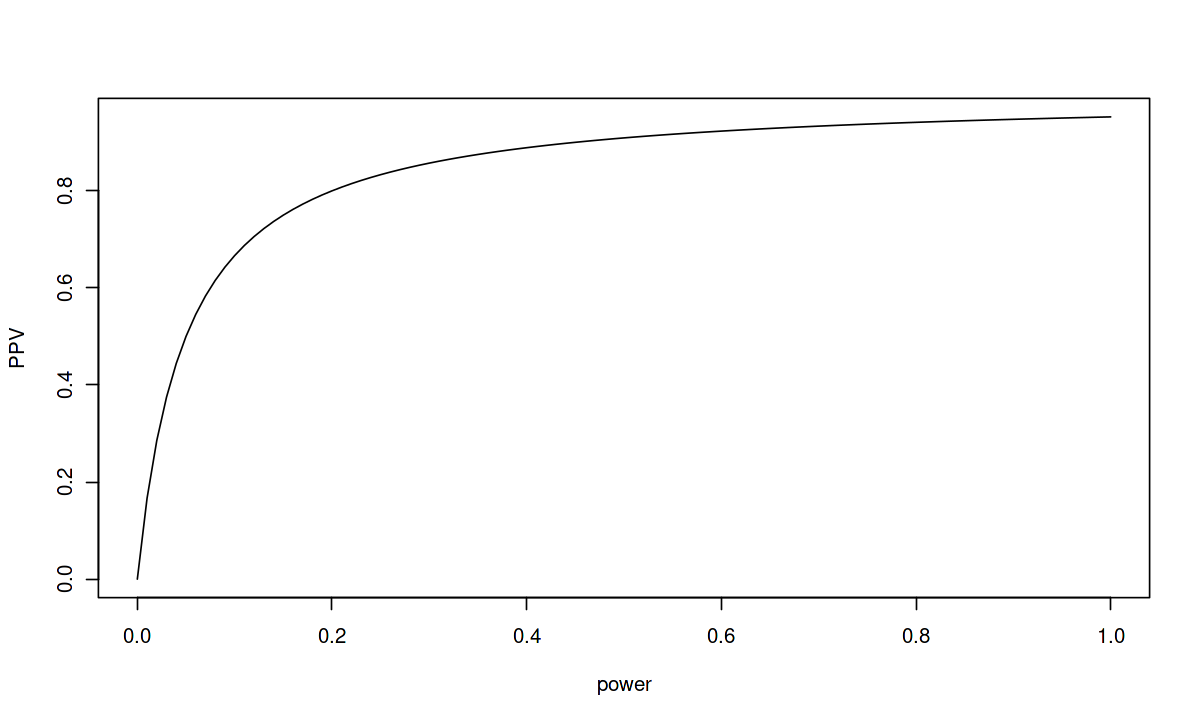

In [199]:
p <- 1e-5
alpha <- 0.05 * p

plot(\(x) x / (x + (1 - p) / p * alpha), from=0, to=1, xlab="power", ylab="PPV")

- When power is low, the PPV is much less than 0.5!

## Researcher bias

- Now suppose that there is a fraction $u\in[0,1]$ of the analyses that would not have been positive findings, but nevertheless end up being reported as positive findings.

\begin{align}
\text{PPV} &= \mathbb{P}(\text{true} \mid \text{significant}) 
\\ &= \frac{p\times [1-(1-u)\beta]  }{p(1-(1-u)\beta) +(1-p)[(1-u)\alpha+u]}
\end{align}

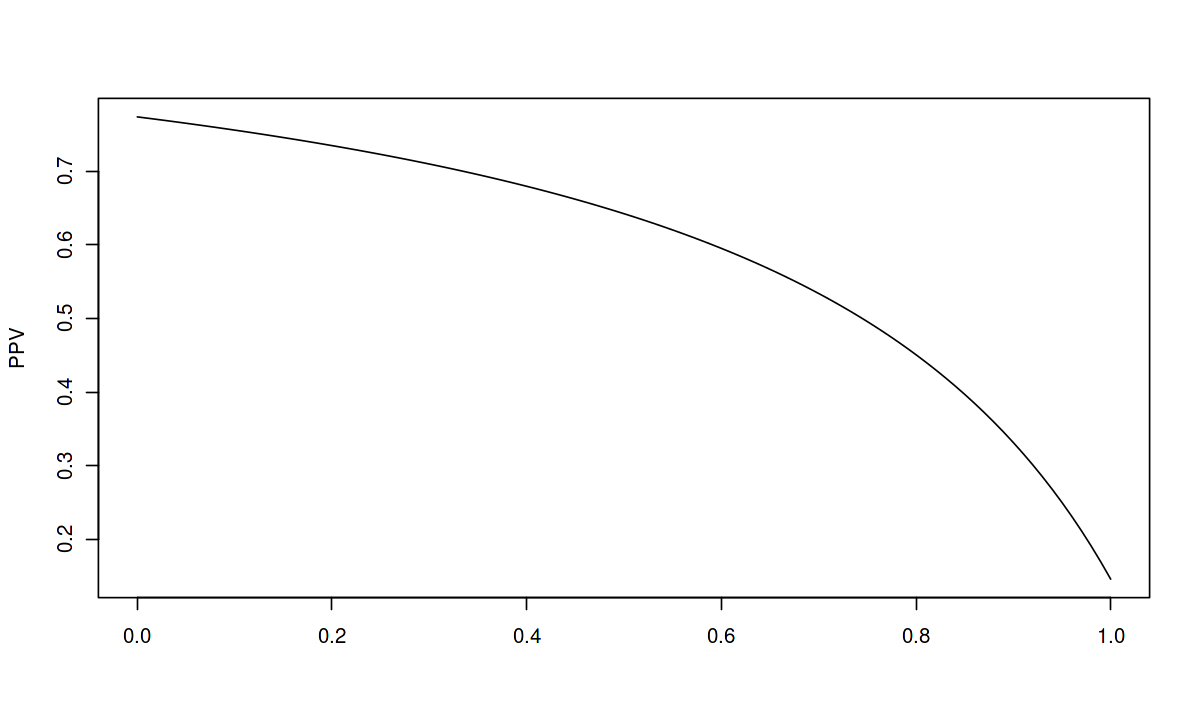

In [205]:
R <- .25 / .75
alpha <- 0.05
u <- 0.05

plot(\(beta) 
     (R*(1-beta)+u*R*beta) / (R*(1-beta) + alpha + u*(1-alpha) + u*beta*R), 
    from=0, to=1, xlab=expression(beta), ylab="PPV")

## How can research bias happen?
- "Data dredging"/p-hacking: Sifting the data until you find a positive association.
- Researcher degrees of freedom: similar, try many different models/data manipulations/
- Subconscious bias: "I know the relationship is true, I just need the data to show it!"

## Researcher degrees of freedom
Every statistical investigation requires you to make a sequence of choices about how to conduct, analyze and report the analysis.
- Data collection: how much data to collect?
- Analysis decisions: how are variables defined? What tests are used? What models are considered?
- What hypotheses will be tested? What results will be reported? Will multiple testing be considered?
- Maliciously exploiting these degrees of freedom is known as p-hacking.
- But even well-intentioned studies can mistakenly fall prey.

## Interactive example


In [207]:
load(url("https://github.com/terhorst/stats504/raw/main/lectures/week9/lifestyle.RData"))

loads a dataframe `lifestyle_df` into your workspace. 
- The dataframe contains some lifestyle variables and measures of systolic blood pressure.
- There is at least one (and possibly more) statistically significant associations between bp and some of the other variables (possibly transformed). **Can you find and report it**?

In [223]:
lm(
    log(SystolicBp) ~ poly(DailyFruitIntake, 3) + 
                    WaterIntake + SmokingStatus * DietType, 
    data=lifestyle_df
) %>% summary 


Call:
lm(formula = log(SystolicBp) ~ poly(DailyFruitIntake, 3) + WaterIntake + 
    SmokingStatus * DietType, data = lifestyle_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.17673 -0.06186 -0.00088  0.05050  0.20302 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          4.741730   0.037094 127.831   <2e-16 ***
poly(DailyFruitIntake, 3)1          -0.159985   0.088676  -1.804   0.0737 .  
poly(DailyFruitIntake, 3)2           0.012982   0.084917   0.153   0.8788    
poly(DailyFruitIntake, 3)3          -0.094520   0.083373  -1.134   0.2591    
WaterIntake                          0.001629   0.003702   0.440   0.6606    
SmokingStatus.L                     -0.024274   0.028902  -0.840   0.4026    
SmokingStatus.Q                      0.022224   0.034202   0.650   0.5171    
DietTypePescatarian                  0.057537   0.023390   2.460   0.0153 *  
DietTypeVegan                        0.034851  

In [144]:
# code